
# El objetivo de este notebook es explicar y llevar a cabo una primera etapa de análisis y visualización de las bases de datos.

Hay dos tipos distintos de archivos como se puede ver en `leyenda.pdf`:
* Datos de uso
* Situaciones de estaciones

## Datos de uso

In [1]:
# Primero vamos a importar el archivo a utilizar
import os

# Obtenemos la ruta absoluta del archivo
ruta_archivo = os.path.join(os.getcwd(), 'datos', 'movements',"202012_movements.json")

# Lo procesamos con Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df_Datos12_2020 = spark.read.json(ruta_archivo)

print("Vamos a mostrar las columnas acerca de los datos\n",df_Datos12_2020.columns)
print("\nMostraremos a continuación un ejemplo de los datos que usamos\n", df_Datos12_2020.take(1))

23/05/28 11:25:45 WARN Utils: Your hostname, ubuntu22 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/05/28 11:25:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/28 11:25:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Vamos a mostrar las columnas acerca de los datos
 ['_id', 'ageRange', 'idplug_base', 'idplug_station', 'idunplug_base', 'idunplug_station', 'travel_time', 'unplug_hourTime', 'user_day_code', 'user_type', 'zip_code']

Mostraremos a continuación un ejemplo de los datos que usamos
 [Row(_id=Row($oid='5fcc10fc1b91315b982817bd'), ageRange=4, idplug_base=16, idplug_station=182, idunplug_base=8, idunplug_station=71, travel_time=337, unplug_hourTime='2020-12-01T00:00:00Z', user_day_code='1b9453cb0a60d9826d01a247deb208cff8f47a4cc74903b09a09571877e10738', user_type=1, zip_code='28012')]


In [3]:
# En el caso que no queramos utilizar alguna columna para el tratamiento de los datos,
# simplemente con .drop(nombre_columna) eliminamos esos datos

df_sin_zip_code = df_Datos12_2020.drop('zip_code')
df_sin_zip_code.columns

['_id',
 'ageRange',
 'idplug_base',
 'idplug_station',
 'idunplug_base',
 'idunplug_station',
 'travel_time',
 'unplug_hourTime',
 'user_day_code',
 'user_type']

Vamos a motrar datos acerca de los usos de BiciMad en función de las edades:


+--------+------+
|ageRange| count|
+--------+------+
|       0|144033|
|       6|  1310|
|       5| 49799|
|       1|  2221|
|       3| 10573|
|       2|  1046|
|       4| 56279|
+--------+------+



/tmp/ipykernel_6033/3503417138.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


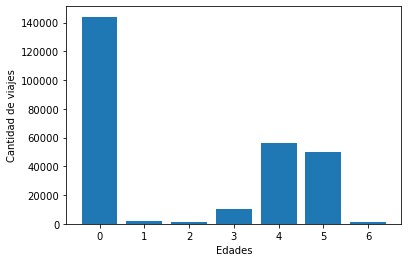

In [4]:
# De manera análoga también podría ser útil trabajar con una sola columna para ello usamos groupBy(nombre_columna)
df_edad = df_Datos12_2020.groupBy('ageRange').count()
print("Vamos a motrar datos acerca de los usos de BiciMad en función de las edades:")
df_edad.show()

#Vamos a realizar un histograma para visualizar los datos de manera gráfica
lista = df_edad.collect()
edad = [i[0] for i in lista]
datos = [i[1] for i in lista]


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(edad,datos)
ax.set_xlabel("Edades")
ax.set_ylabel("Cantidad de viajes")
fig.show()

**Ahora vamos a realizar vamos a mostrar una opción de preprocesado de datos**

Supongamos que queremos eliminar la edad de tipo '0' debido a que no nos ofrece información de la edad, utilizaremos filter.
Hagamos esto para el caso anterior.


/tmp/ipykernel_6033/162272001.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


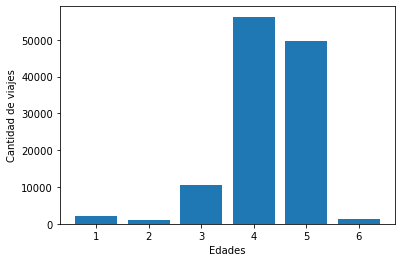

In [5]:
df_filter0 = df_Datos12_2020.filter(df_Datos12_2020['ageRange'] != 0 )
df_filter0 = df_filter0.groupBy('ageRange').count()

edad = df_filter0.select("ageRange")
datos = df_filter0.select("count")


lista = df_filter0.collect()
edad = [i[0] for i in lista]
datos = [i[1] for i in lista]


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(list(edad),list(datos))
ax.set_xlabel("Edades")
ax.set_ylabel("Cantidad de viajes")
fig.show()

### Vamos a mostrar un ejemplo de lo que haremos gracias a estos datos:

#### Búsqueda del cliente objetivo

Nuestra idea para trabajar en este problema es contabilizar datos acerca de los clientes en función de:

1. Edad (*ageRange*).
2. Tiempo de viaje (*travel_time*).
3. zona de uso.


Comenzaremos realizando un filtrado de datos

* En relación a la edad nos interesa eliminar el 0 que no ofrece datos sobre la edad.

* En relación al tiempo de uso deberemos de eliminar los viajes de menos de 60 segundos, pues estos podrían estar relacionados con errore como
que no funcione la bici, o que hayas cambiado de opinión sobre usar la bici.

* En relación al código postal, debemos tomar aquellos clientes cuyo código postal comience por 28 que es el correspondiente a Madrid.

* Podemos eliminar también los trabajadores de la empresa biciMad ya que esta dirigido a los clientes.

* Además de más factores que se añadirán en la práctica

In [7]:

df_filtrado = df_Datos12_2020.filter(
    (df_Datos12_2020['ageRange'] != 0) &
    (df_Datos12_2020['travel_time'] > 60) &
    (df_Datos12_2020['zip_code'][0:2] == '28') &
    (df_Datos12_2020['user_type'] != 3)
)


#Podemos realizar clusters sobre el tiempo o calcular la media simplemente
from pyspark.sql.functions import mean

travel_time = df_filtrado.select(['travel_time'])
mean_time = df_filtrado.select(mean('travel_time')).collect()[0][0]
print(f"El tiempo medio de viaje es: {int(mean_time // 60)} minutos y {int(mean_time % 60)} segundos")

df_filtrado.groupBy(['zip_code']).count().show() #Cabe resaltar que hay códigos postales que no tienen sentido y habría que eliminar 


El tiempo medio de viaje es: 15 minutos y 32 segundos


+--------+-----+
|zip_code|count|
+--------+-----+
|   28039| 1415|
|   28500|   53|
|  28028 |    7|
|   28600|   19|
|28002   |   20|
|   28707|   24|
|   28053|  429|
|   28034|  206|
|   28341|   11|
|   28945|    9|
|   28914|   34|
|   28019|  973|
|   28400|   87|
|   28220|   85|
|   28840|   20|
|   28020| 2565|
|   28450|   12|
|   28027|  989|
|   28011| 1040|
|   28350|    8|
+--------+-----+
only showing top 20 rows



In [8]:
#Vamos a finalizar la anterior sesion de spark
spark.stop()

#### Ahora vamos a trabajar con los archivos de otra forma distinta al DataFrame, usando rdd. 

Al ver dos formas distintas de trabajar vamos a poder analizar y comprender las ventajas y desventajes con el fin de saber que opción utilizar en cada uno de los casos que se presentarán en los problemas


In [11]:
#Mostramos el contenido del archivo de movements
import subprocess

ruta_archivo = '/home/david/Escritorio/BiciMad/datos/movements/202012_movements.json'
# Ejecuta el comando head -10 en la ruta del archivo
resultado = subprocess.run(['head', '-10', ruta_archivo], capture_output=True, text=True)

# Imprime el resultado
print(resultado.stdout)


{"_id": {"$oid": "5fcc10fc1b91315b982817bd"}, "user_day_code": "1b9453cb0a60d9826d01a247deb208cff8f47a4cc74903b09a09571877e10738", "idplug_base": 16, "user_type": 1, "idunplug_base": 8, "travel_time": 337, "idunplug_station": 71, "ageRange": 4, "idplug_station": 182, "unplug_hourTime": "2020-12-01T00:00:00Z", "zip_code": "28012"}
{"_id": {"$oid": "5fcc10fc1b91315b982817be"}, "user_day_code": "29fe8cf0fb57fdfc4c1ef5a51fbd1222afea11d33a6e090a0b642ee1b92b2aa8", "idplug_base": 19, "user_type": 1, "idunplug_base": 1, "travel_time": 190, "idunplug_station": 35, "ageRange": 0, "idplug_station": 18, "unplug_hourTime": "2020-12-01T00:00:00Z", "zip_code": ""}
{"_id": {"$oid": "5fcc10fc1b91315b982817c0"}, "user_day_code": "051f14e387dd8f5442f9c4cd6e3db915c48ff64bbb8c531df085b392d902ee25", "idplug_base": 14, "user_type": 1, "idunplug_base": 21, "travel_time": 354, "idunplug_station": 46, "ageRange": 4, "idplug_station": 175, "unplug_hourTime": "2020-12-01T00:00:00Z", "zip_code": "28012"}
{"_id": {

In [14]:
from pyspark import SparkContext
sc = SparkContext()


In [15]:
import json

rdd_Datos12_2020 = sc.textFile(ruta_archivo)

In [16]:
#Si queremos una columna en especial

def columna(line):
    data = json.loads(line)
    u_t = data['user_type']
    return u_t

tipo_usuarios = rdd_Datos12_2020.map(columna)

tipo_usuarios.take(10)

#Si queremos la cantidad de usuarios estableciendo un sistema de valores donde su valor está en función de su tipo de usuario

tipo_usuarios.count()

265261

#### Vamos a quedarnos con los datos del fichero que nos interesen

In [17]:

def mapper(line):
    data = json.loads(line)
    u_t = data['user_type']
    u_c = data['user_day_code']
    start = data['idunplug_station']
    end = data['idplug_station']
    time = data['travel_time']
    return u_t, u_c, start, end, time

rdd = rdd_Datos12_2020.map(mapper)
rdd.take(2)

[(1,
  '1b9453cb0a60d9826d01a247deb208cff8f47a4cc74903b09a09571877e10738',
  71,
  182,
  337),
 (1,
  '29fe8cf0fb57fdfc4c1ef5a51fbd1222afea11d33a6e090a0b642ee1b92b2aa8',
  35,
  18,
  190)]

#### Vamos a realizar un proceso análogo al que hicimos con las edades

/tmp/ipykernel_6033/2284089792.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Mostrados los datos en relación a las edades defaultdict(<class 'int'>, {4: 56279, 0: 144033, 5: 49799, 3: 10573, 1: 2221, 6: 1310, 2: 1046})


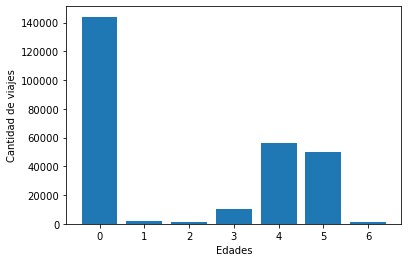

In [20]:

def map_age(line):
    data = json.loads(line)
    a_r = data['ageRange']
    return a_r

edades = rdd_Datos12_2020.map(map_age).countByValue()
print("Mostrados los datos en relación a las edades",edades)

#Realizaremos un histograma como antes
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(list(edades.keys()),list(edades.values()))
ax.set_xlabel("Edades")
ax.set_ylabel("Cantidad de viajes")
fig.show()


#### Vamos a mostrar como haríamos filtrado de datos

In [22]:
select_type = 1
rdd_users = rdd.filter(lambda x: x[0] == select_type).map(lambda x: (x[1],tuple(x[2:])))

rdd_users.take(2)

print("La cantidad de usuarios tipo 1 es:" ,rdd_users.count())

La cantidad de usuarios tipo 1 es: 255154


#### Vamos a comenzar con el trabajo de uno de los problemas posteriormente propuestos que tiene relación con las estaciones de origen y destino

In [23]:
#Cantidad total de viajes
rdd_trips = rdd_users.map(lambda x: (x[1][0],x[1][1]))
rdd_trips.take(2)

print("La cantidad de viajes es:", rdd_trips.count())

La cantidad de viajes es: 255154


In [32]:
# Cerramos la sesión activa
sc.stop()

## Situaciones de estaciones

Vamos a comenzar trabajando con datos de las estaciones con el fin de trabajar con un mapa que contenga los datos sobre las bicicletas disponibles

Observación: aunque haya librerías importadas previamente las volvemos a importar ya que una de las utilidades de este notebook es mostrar las herramientas para trabajar con la resolución de problemas

In [3]:
import json
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('example').getOrCreate()

In [4]:
# Primero vamos a importar el archivo a utilizar
import os

# Obtenemos la ruta absoluta del archivo
ruta_archivo = os.path.join(os.getcwd(), 'datos', 'stations',"202012_stations.json")

df_Situaciones12_2020 = spark.read.json(ruta_archivo)
print("Vamos a obtener las columnas\n" ,df_Situaciones12_2020.columns)
print("\nVamos a mostar un ejemplo de los datos a usar\n", df_Situaciones12_2020.take(1))


Vamos a obtener las columnas
 ['_id', 'stations']



Vamos a mostar un ejemplo de los datos a usar
 [Row(_id='2020-12-01T00:56:04.683755', stations=[Row(activate=1, address='Puerta del Sol nº 1', dock_bikes=3, free_bases=26, id=1, latitude='40.4172137', light=0, longitude='-3.7018341', name='Puerta del Sol A', no_available=0, number='1a', reservations_count=0, total_bases=30), Row(activate=1, address='Puerta del Sol nº 1', dock_bikes=9, free_bases=18, id=2, latitude='40.41731271011562', light=2, longitude='-3.701602938060457', name='Puerta del Sol B', no_available=0, number='1b', reservations_count=0, total_bases=30), Row(activate=1, address='Calle Miguel Moya nº 1', dock_bikes=3, free_bases=19, id=3, latitude='40.4205886', light=0, longitude='-3.7058415', name='Miguel Moya', no_available=0, number='2', reservations_count=0, total_bases=24), Row(activate=1, address='Plaza del Conde Suchil nº 2-4', dock_bikes=12, free_bases=5, id=4, latitude='40.4302937', light=1, longitude='-3.7069171', name='Plaza Conde Suchil', no_available=0, number=

In [7]:
#Vamos a seleccionar stations
stations = df_Situaciones12_2020.select('stations')
print("Vamos a obtener las columnas\n" ,stations.columns) 
print("\nVamos a mostar un ejemplo de los datos a usar\n", stations.take(1))

Vamos a obtener las columnas
 ['stations']

Vamos a mostar un ejemplo de los datos a usar
 [Row(stations=[Row(activate=1, address='Puerta del Sol nº 1', dock_bikes=3, free_bases=26, id=1, latitude='40.4172137', light=0, longitude='-3.7018341', name='Puerta del Sol A', no_available=0, number='1a', reservations_count=0, total_bases=30), Row(activate=1, address='Puerta del Sol nº 1', dock_bikes=9, free_bases=18, id=2, latitude='40.41731271011562', light=2, longitude='-3.701602938060457', name='Puerta del Sol B', no_available=0, number='1b', reservations_count=0, total_bases=30), Row(activate=1, address='Calle Miguel Moya nº 1', dock_bikes=3, free_bases=19, id=3, latitude='40.4205886', light=0, longitude='-3.7058415', name='Miguel Moya', no_available=0, number='2', reservations_count=0, total_bases=24), Row(activate=1, address='Plaza del Conde Suchil nº 2-4', dock_bikes=12, free_bases=5, id=4, latitude='40.4302937', light=1, longitude='-3.7069171', name='Plaza Conde Suchil', no_available=0

Ahora vamos a realizar una selección de datos para crear un mapa que será una parte fundamental en el desarrollo de uno de los problemas
 * name
 * longitude
 * latitude
 * id

In [11]:
from pyspark.sql.functions import col
seleccion = df_Situaciones12_2020.select(col("stations.name"), col("stations.longitude"), col("stations.latitude"),col("stations.id"))

datos_seleccionados = (seleccion
                .select(col("name"), col("latitude"), col("longitude"), col("id"))
                .collect())

result = []
for row in datos_seleccionados:
    result.append({"name": row["name"], "latitude": row["latitude"], "longitude": row["longitude"], "id": row["id"]})


{'name': ['Puerta del Sol A',
  'Puerta del Sol B',
  'Miguel Moya',
  'Plaza Conde Suchil',
  'Malasaña',
  'Fuencarral',
  'Colegio Arquitectos',
  'Hortaleza',
  'Alonso Martínez',
  'Plaza de San Miguel',
  'Marqués de la Ensenada',
  'San Andrés',
  'San Hermenegildo',
  'Conde Duque',
  'Ventura Rodríguez',
  'San Vicente Ferrer',
  'San Bernardo',
  'Carlos Cambronero',
  'Plaza de Pedro Zerolo',
  'Prim',
  'Banco de España A',
  'Jacometrezo',
  'Santo Domingo',
  'Palacio de Oriente',
  'Plaza de Celenque A',
  'Plaza de Celenque B',
  'Plaza de las Salesas',
  'Huertas',
  'Sevilla',
  'Marqués de Cubas',
  'San Quintín',
  'Calle Mayor',
  'Plaza de la Provincia',
  'Carretas',
  'Jacinto Benavente',
  'Plaza del Cordón',
  'Plaza de Ramales',
  'Plaza San Francisco',
  'Plaza de los Carros',
  'Plaza de la Cebada',
  'Conde de Romanones',
  'Antón Martín',
  'Santa Isabel',
  'Jesús y María',
  'Plaza de Nelson Mandela',
  'Puerta de Toledo',
  'Ribera de Curtidores',
  'E

Para esta parte del trabajo sólo necesitamos una línea ya que contiene toda la información necesaria para la creación del mapa

In [12]:
linea = result[0]
datos_usar = {}

for key, values in linea.items():
    for i, value in enumerate(values):
        datos_usar.setdefault(i, {})
        datos_usar[i][key] = value
        
print(datos_usar)


{0: {'name': 'Puerta del Sol A', 'latitude': '40.4172137', 'longitude': '-3.7018341', 'id': 1}, 1: {'name': 'Puerta del Sol B', 'latitude': '40.41731271011562', 'longitude': '-3.701602938060457', 'id': 2}, 2: {'name': 'Miguel Moya', 'latitude': '40.4205886', 'longitude': '-3.7058415', 'id': 3}, 3: {'name': 'Plaza Conde Suchil', 'latitude': '40.4302937', 'longitude': '-3.7069171', 'id': 4}, 4: {'name': 'Malasaña', 'latitude': '40.4285524', 'longitude': '-3.7025875', 'id': 5}, 5: {'name': 'Fuencarral', 'latitude': '40.42852', 'longitude': '-3.70205', 'id': 6}, 6: {'name': 'Colegio Arquitectos', 'latitude': '40.4241480', 'longitude': '-3.6984470', 'id': 7}, 7: {'name': 'Hortaleza', 'latitude': '40.4251906', 'longitude': '-3.6977715', 'id': 8}, 8: {'name': 'Alonso Martínez', 'latitude': '40.4278682', 'longitude': '-3.6954403', 'id': 9}, 9: {'name': 'Plaza de San Miguel', 'latitude': '40.4156057', 'longitude': '-3.7095084', 'id': 10}, 10: {'name': 'Marqués de la Ensenada', 'latitude': '40.4

Vamos a realizar la función para transformar el formato de la fecha a otro más sencillo

In [6]:

fechas = ['2020-12-01T00:56:04.683755', '2020-12-01T01:56:05.745624', '2020-12-01T02:56:07.043903']

from datetime import datetime
def fecha_util(line):

    return datetime.strptime(line, "%Y-%m-%dT%H:%M:%S.%f")

print("\nUn ejemplo de convertirlo a fecha Año-Mes-Dia,Hora,Minutos,Segundos es:",fecha_util('2020-12-01T00:56:04.683755'))
print(f"Vamos a convertir 2020-12-01T00:56:04.683755: \n {fecha_util('2020-12-01T00:56:04.683755')} ")


Un ejemplo de convertirlo a fecha Año-Mes-Dia,Hora,Minutos,Segundos es: 2020-12-01 00:56:04.683755
Vamos a convertir 2020-12-01T00:56:04.683755: 
 2020-12-01 00:56:04.683755 
